In [124]:
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
from brainlit.utils.Neuron_trace import NeuronTrace
from mpl_toolkits.mplot3d import Axes3D
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from scipy.interpolate import splev
import seaborn as sns 

## Define brain, find trace data folder

In [142]:
#specify brain1 or brain2 below
brain = "brain1"

root_dir = Path(os.path.abspath('')).parents[1]
experiment_dir = os.path.join(root_dir, "axon_geometry")
data_dir = os.path.join(experiment_dir, "data", brain)
segments_swc_dir = os.path.join(data_dir, "segments_swc")
trace_data_dir = os.path.join(data_dir, "trace_data")
trace_data_dir = os.path.join(trace_data_dir, "14")
print(f"Directory where swcs reside: {segments_swc_dir}")

Directory where swcs reside: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/axon_geometry/data/brain1/segments_swc


## Read trace data

In [143]:
max_id = 300


def classify_height(row):
    height = row["height"]
    if height <= 2:
        return height
    else:
        return 3

def numerical_class(row):
    _class = row["class"]
    if _class == "primary":
        return 0
    if _class == "collateral":
        return 1
    if _class == "terminal":
        return 2

df_path = os.path.join(trace_data_dir, "df.csv")
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    df = pd.DataFrame(columns=["seg_id", "class", "height", "log_seg_length", "measure", "value", "log_value"])
    for i in tqdm(np.arange(0, max_id)):
        i = int(i)
        trace_data_path = os.path.join(trace_data_dir, "{}.npy".format(i))
        if os.path.exists(trace_data_path) is True:
            trace_data = np.load(trace_data_path, allow_pickle=True)

            for node in trace_data:
                seg_length = node["seg_length"]
                height = node["height"]
                _class = node["class"]
                mean_curvature = node["mean_curvature"]
                mean_torsion = node["mean_torsion"]
                
                log_seg_length = np.log10(seg_length)

                log_mean_curvature = np.log10(mean_curvature)
                df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "curvature", "value": mean_curvature, "log_value": log_mean_curvature}, ignore_index=True)

                log_mean_torsion = np.log10(mean_torsion)
                df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "torsion", "value": mean_torsion, "log_value": log_mean_torsion}, ignore_index=True)
    df.to_csv(df_path)
df["class"] = df.apply(numerical_class, axis=1)
df["height_class"] = df.apply(classify_height, axis=1)

## Count number of neurons that fall into different orderings

In [144]:
measures = ["curvature", "torsion"]

classes = {0: "primary", 1: "collateral", 2: "terminal"}
n = len(classes)
data = np.zeros((2,3))
df_order = pd.DataFrame(columns=["Curvature Order", "Torsion Order", "Neuron Index"])


matrix_pairs = np.triu(np.ones((n, n)), k=1)
(coord_pairs_x, coord_pairs_y) = np.where(matrix_pairs == 1)

example1_idxs = []
example2_idxs = []

for i in tqdm(np.arange(0, max_id)):
    sample_query = df.loc[(df['seg_id'] == i)]
    num_segments = len(sample_query.index)
    if num_segments == 0:
        continue

    for row, measure in enumerate(measures):
        for col, clas in enumerate(classes.keys()):
            sample_query = df.loc[(df['seg_id'] == i) & (df['class'] == clas) & (df['measure'] == measure)]
            value = np.mean(sample_query["value"].to_numpy())
            data[row, col] = value

    if data[0,0] > data[0,1] and data[0,1] > data[0,2]:
        curv_order = "P > C > T"
    elif data[0,0] > data[0,2] and data[0,2] > data[0,1]:
        curv_order = "P > T > C"
    elif data[0,1] > data[0,0] and data[0,0] > data[0,2]: 
        curv_order = "C > P > T"
    elif data[0,1] > data[0,2] and data[0,2] > data[0,0]: # collateral > terminal > primary
        curv_order = "C > T > P"
    elif data[0,2] > data[0,0] and data[0,0] > data[0,1]:
        curv_order = "T > P > C"
    elif data[0,2] > data[0,1] and data[0,1] > data[0,0]:
        curv_order = "T > C > P"

    if data[1,0] > data[1,1] and data[1,1] > data[1,2]:
        tor_order = "P > C > T"
    elif data[1,0] > data[1,2] and data[1,2] > data[1,1]:
        tor_order = "P > T > C"
    elif data[1,1] > data[1,0] and data[1,0] > data[1,2]: # collateral > primary > terminal
        tor_order = "C > P > T"
    elif data[1,1] > data[1,0] and data[1,2] > data[1,0]:
        tor_order = "C > T > P"
    elif data[1,2] > data[1,0] and data[1,0] > data[1,1]:
        tor_order = "T > P > C"
    elif data[1,2] > data[1,1] and data[1,1] > data[1,0]:
        tor_order = "T > C > P"

    df_order = df_order.append({"Curvature Order": curv_order, "Torsion Order": tor_order, "Neuron Index": i},ignore_index=True)



100%|██████████| 300/300 [00:05<00:00, 55.68it/s]


In [145]:
df_counts = pd.DataFrame(columns = ["Curvature Order", "Torsion Order", "Count"])

for curv_order in ["P > C > T", "P > T > C", "C > P > T", "C > T > P", "T > P > C", "T > C > P"]:
    for tor_order in ["P > C > T", "P > T > C", "C > P > T", "C > T > P", "T > P > C", "T > C > P"]:
        count = df_order.loc[(df_order['Curvature Order'] == curv_order) & (df_order['Torsion Order'] == tor_order)].shape[0]
        df_counts = df_counts.append({"Curvature Order": curv_order, "Torsion Order": tor_order, "Count": count}, ignore_index=True)

df_counts = df_counts.astype({"Count": 'int32'})
df_counts = df_counts.pivot("Curvature Order", "Torsion Order", "Count")

## Display heatmap of ordering frequencies and save image

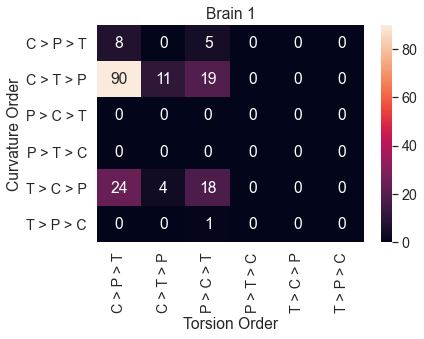

In [147]:
sns.set(font_scale=1.3)
ax = sns.heatmap(df_counts, annot=True)
title = "Brain " + brain[-1]
ax.set_title(title)
filename = brain + "_heatmap.png"
out_path = os.path.join(experiment_dir, "figures",  filename)
plt.savefig(out_path, dpi=400, bbox_inches='tight')

### Define helper function

In [148]:
def node_height(G, node):
    predecessors = list(G.predecessors(node))
    L = len(predecessors)
    assert L == 1 or L == 0
    if L == 0:
        return 0
    else:
        return 1 + node_height(G, predecessors[0])

## Plot and save neuron image
User should specify `plot_common_ordering`, `idx`

Loaded segment 2


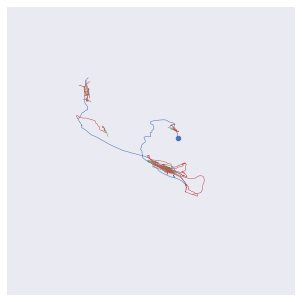

In [149]:
# if true, will plot a neuron whose curvature/torsion ordering is the most common (collaterl>terminal>primary for curvature collaterl>primary>terminal for torsion)
# if false, will plot a neuron that has a different ordering
plot_common_ordering = True 
# index of the neuron within the class specified by plot_common_ordering above
idx = 0

if plot_common_ordering:
    i = df_order.loc[(df_order['Curvature Order'] == "C > T > P") & (df_order['Torsion Order'] == "C > P > T")]["Neuron Index"].iloc[idx]
else:
    i = df_order.loc[(df_order['Curvature Order'] == "C > T > P") & (df_order['Torsion Order'] == "C > P > T")]["Neuron Index"].iloc[idx]


string_id = str(i).zfill(3)
seg_swc_path = os.path.join(
    segments_swc_dir,
    "{}_G-{}_consensus.swc".format(
        "2018-08-01" if brain == "brain1" else "2018-12-01", string_id
    ),
)
swc_trace = NeuronTrace(path=seg_swc_path)
df_swc_offset_neuron = swc_trace.get_df()

print("Loaded segment {}".format(i))
G = GeometricGraph(df=df_swc_offset_neuron)
spline_tree = G.fit_spline_tree_invariant()

fig = plt.figure()
ax = Axes3D(fig)

for j, node in enumerate(spline_tree.nodes):
    spline = spline_tree.nodes[node]
    spline_height = node_height(spline_tree, node)
    tck, u_um = spline["spline"]
    y = splev(np.arange(u_um[0],u_um[-1], 0.1), tck)

    if spline_height == 0:
        c = "b"
        ax.scatter(y[0][0],y[1][0],y[2][0],'b')
    else:
        successors = spline_tree.successors(node)
        if len(list(successors)) == 0:
            c = "g"
        else:
            c = "r"

    ax.plot(y[0], y[1], y[2], c, linewidth=0.5)

ax.set_axis_off()


if plot_common_ordering:
    filename = brain + "_common_order.png"
else:
    filename = brain + "_not_common_order.png"

out_path = os.path.join(experiment_dir, "figures",  filename)
plt.savefig(out_path, dpi=400)

## Look at all neurons in the different groups

Loaded segment 5


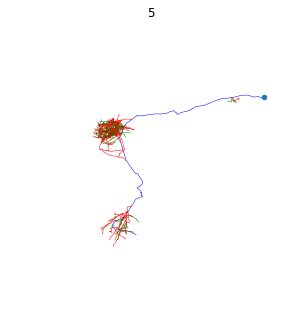

Loaded segment 7


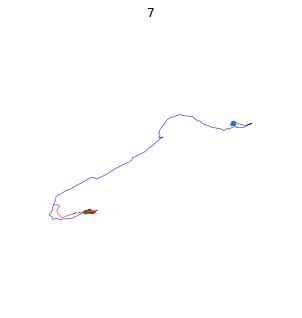

Loaded segment 10


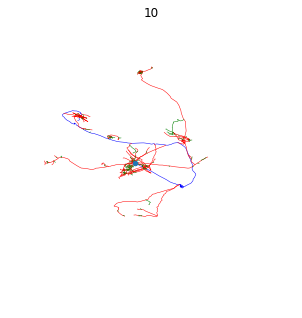

Loaded segment 12


KeyboardInterrupt: 

In [9]:
for i in example1_idxs:
    string_id = str(i).zfill(3)
    seg_swc_path = os.path.join(
        segments_swc_dir,
        "{}_G-{}_consensus.swc".format(
            "2018-08-01" if brain == "brain1" else "2018-12-01", string_id
        ),
    )
    swc_trace = NeuronTrace(path=seg_swc_path)
    df_swc_offset_neuron = swc_trace.get_df()

    print("Loaded segment {}".format(i))
    G = GeometricGraph(df=df_swc_offset_neuron)
    spline_tree = G.fit_spline_tree_invariant()

    fig = plt.figure()
    ax = Axes3D(fig)

    for j, node in enumerate(spline_tree.nodes):
        spline = spline_tree.nodes[node]
        spline_height = node_height(spline_tree, node)
        tck, u_um = spline["spline"]
        y = splev(np.arange(u_um[0],u_um[-1], 0.1), tck)

        if spline_height == 0:
            c = "b"
            ax.scatter(y[0][0],y[1][0],y[2][0],'b')
        else:
            successors = spline_tree.successors(node)
            if len(list(successors)) == 0:
                c = "g"
            else:
                c = "r"

        ax.plot(y[0], y[1], y[2], c, linewidth=0.5)

    ax.set_axis_off()
    ax.set_title(i)
    plt.show()